In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import PIL
import PIL.Image
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers

import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
maxEpoch = 30
from sklearn.metrics import classification_report
numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print('Num GPUs Available: ', numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)

2022-11-06 18:12:37.663526: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Num GPUs Available:  1
/device:GPU:0
device: XLA_CPU device


2022-11-06 18:12:39.529346: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-06 18:12:39.558711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 18:12:39.558816: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2022-11-06 18:12:39.558829: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-06 18:12:39.560759: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-06 18:12:39.560789: I tensorflow/stream_executor/plat

In [2]:
#tfds.list_builders()  4 fin min are you kidding me

In [3]:
# ds = tfds.load('resisc45', split='train', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
# print(ds)



In [4]:
# ds, ds_info = tfds.load('resisc45', split='train', with_info=True)
# fig = tfds.show_examples(ds, ds_info)

# print(ds_info)

In [5]:


data_dir = pathlib.Path("/home/nate/tensorflow_datasets/downloads/manual/NWPU-RESISC45/")



In [6]:
# image_count = len(list(data_dir.glob('*/*.jpg')))
# print(image_count)


In [7]:
# airplane = list(data_dir.glob('airplane/*'))
# PIL.Image.open(str(airplane[0]))

In [8]:
batch_size = 32
img_height = 256
img_width = 256

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 31500 files belonging to 45 classes.
Using 25200 files for training.


2022-11-06 18:12:40.680241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 18:12:40.680462: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2022-11-06 18:12:40.680485: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-06 18:12:40.680518: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-06 18:12:40.680531: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-11-06 18:12:40.680541: I tensorflow/stream_executor

In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 31500 files belonging to 45 classes.
Using 6300 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'medium_residential', 'mobile_home_park', 'mountain', 'overpass', 'palace', 'parking_lot', 'railway', 'railway_station', 'rectangular_farmland', 'river', 'roundabout', 'runway', 'sea_ice', 'ship', 'snowberg', 'sparse_residential', 'stadium', 'storage_tank', 'tennis_court', 'terrace', 'thermal_power_station', 'wetland']


In [12]:
# (train_ds, val_ds, test_ds), info_ds = tfds.load('resisc45', split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'], as_supervised=True, with_info=True)
# feats = info_ds.features["label"].names
# print(info_ds)
# train_ds

In [13]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
train_ds

2022-11-06 18:12:41.279816: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


0.011764707 1.0


<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Epoch 1/30


2022-11-06 18:12:41.882137: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-06 18:12:42.105308: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-11-06 18:12:42.845708: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-11-06 18:12:42.899522: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


788/788 [==============================] - 79s 92ms/step - loss: 3.4223 - accuracy: 0.1081 - val_loss: 2.5201 - val_accuracy: 0.2903
Epoch 2/30
788/788 [==============================] - 23s 30ms/step - loss: 2.2773 - accuracy: 0.3522 - val_loss: 2.0711 - val_accuracy: 0.4087
Epoch 3/30
788/788 [==============================] - 23s 30ms/step - loss: 1.5925 - accuracy: 0.5391 - val_loss: 2.2088 - val_accuracy: 0.4160
Epoch 4/30
788/788 [==============================] - 23s 30ms/step - loss: 0.9950 - accuracy: 0.7111 - val_loss: 2.6264 - val_accuracy: 0.4097
Epoch 5/30
788/788 [==============================] - 23s 30ms/step - loss: 0.5815 - accuracy: 0.8312 - val_loss: 3.4236 - val_accuracy: 0.3813
Epoch 6/30
788/788 [==============================] - 24s 30ms/step - loss: 0.3714 - accuracy: 0.8921 - val_loss: 4.1284 - val_accuracy: 0.3838
Epoch 7/30
788/788 [==============================] - 23s 30ms/step - loss: 0.2817 - accuracy: 0.9148 - val_loss: 5.0257 - val_accuracy: 0.3808
Epo

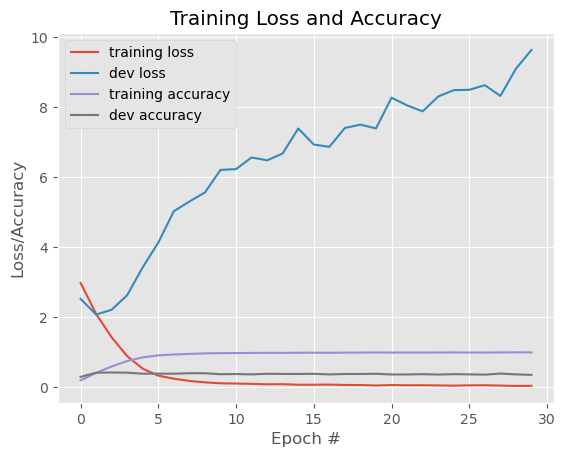

In [16]:
num_classes = 45

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=maxEpoch
)

Realy = np.concatenate([y for x, y in val_ds], axis = 0)
predY = model.predict(val_ds)
predY = predY.argmax(axis=1)

print(Realy, "\n",predY)
print(classification_report(Realy, predY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Epoch 1/30
788/788 [==============================] - 55s 57ms/step - loss: 4.3347 - accuracy: 0.0230 - val_loss: 3.7913 - val_accuracy: 0.0225
Epoch 2/30
788/788 [==============================] - 25s 31ms/step - loss: 3.7283 - accuracy: 0.0422 - val_loss: 3.5826 - val_accuracy: 0.0640
Epoch 3/30
788/788 [==============================] - 25s 31ms/step - loss: 3.5573 - accuracy: 0.0721 - val_loss: 3.4987 - val_accuracy: 0.0798
Epoch 4/30
788/788 [==============================] - 25s 31ms/step - loss: 3.4817 - accuracy: 0.0890 - val_loss: 3.4352 - val_accuracy: 0.1084
Epoch 5/30
788/788 [==============================] - 25s 31ms/step - loss: 3.3772 - accuracy: 0.1068 - val_loss: 3.2478 - val_accuracy: 0.1230
Epoch 6/30
788/788 [==============================] - 25s 31ms/step - loss: 3.1588 - accuracy: 0.1406 - val_loss: 3.0536 - val_accuracy: 0.1568
Epoch 7/30
788/788 [==============================] - 24s 31ms/step - loss: 3.0141 - accuracy: 0.1667 - val_loss: 3.0252 - val_accuracy:

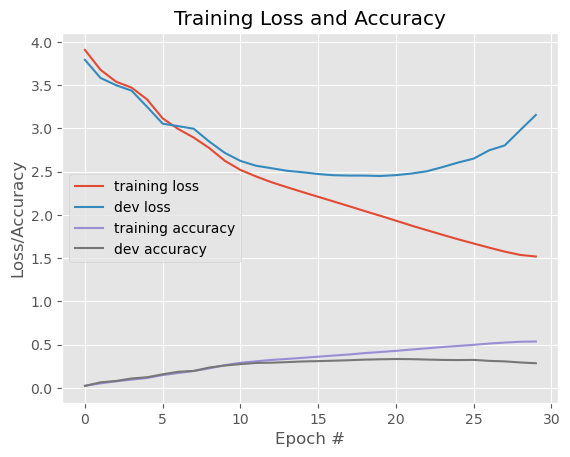

In [17]:
num_classes = 45

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='sigmoid'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='sigmoid'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=maxEpoch
)

Realy = np.concatenate([y for x, y in val_ds], axis = 0)
predY = model.predict(val_ds)
predY = predY.argmax(axis=1)

print(Realy, "\n",predY)
print(classification_report(Realy, predY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [18]:
val_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Next I am goign to try a more tradiontal Lnett that we talked about in class.

Epoch 1/30


2022-11-06 18:37:58.740531: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2022-11-06 18:37:58.797596: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 2.55G (2734239232 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


788/788 [==============================] - 139s 138ms/step - loss: 3.9471 - accuracy: 0.0705 - val_loss: 2.7367 - val_accuracy: 0.2506
Epoch 2/30
788/788 [==============================] - 67s 85ms/step - loss: 2.3438 - accuracy: 0.3447 - val_loss: 2.8121 - val_accuracy: 0.3149
Epoch 3/30
788/788 [==============================] - 67s 85ms/step - loss: 1.3716 - accuracy: 0.6006 - val_loss: 3.9840 - val_accuracy: 0.2910
Epoch 4/30
788/788 [==============================] - 67s 85ms/step - loss: 0.6060 - accuracy: 0.8328 - val_loss: 5.3145 - val_accuracy: 0.2838
Epoch 5/30
788/788 [==============================] - 67s 85ms/step - loss: 0.2416 - accuracy: 0.9342 - val_loss: 5.9729 - val_accuracy: 0.2924
Epoch 6/30
788/788 [==============================] - 66s 84ms/step - loss: 0.1369 - accuracy: 0.9624 - val_loss: 6.3764 - val_accuracy: 0.2868
Epoch 7/30
788/788 [==============================] - 67s 85ms/step - loss: 0.0876 - accuracy: 0.9754 - val_loss: 7.1313 - val_accuracy: 0.2679
E

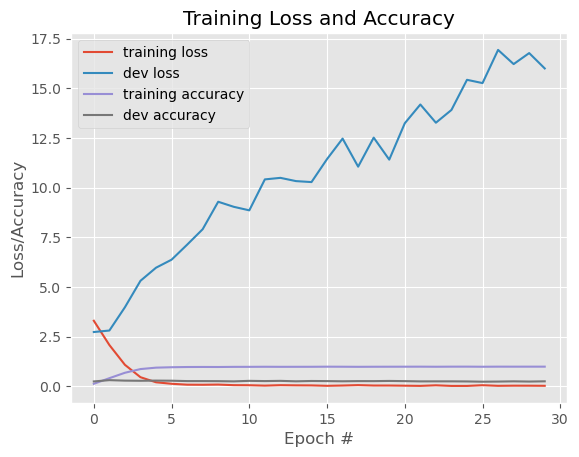

In [19]:
# create a feedforward neural net
#lnet
height = width = 256
depth = 3
classes = 45
model = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

# add a convolutional layer with 20 5x5 filters and a 2x2 max pooling layer
tf.keras.layers.Conv2D(32, (5, 5), padding = 'same', input_shape = (height, width, depth)),
tf.keras.layers.Activation('relu'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),

# add another convolutional layer with 50 5x5 filters and a 2x2 max pooling layer
tf.keras.layers.Conv2D(64, (5, 5), padding= 'same'),
tf.keras.layers.Activation('relu'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),

# add another convolutional layer
tf.keras.layers.Conv2D(128, (5, 5), padding = 'same'),
tf.keras.layers.Activation('relu'),

# add a fully-connected layer
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(500),
tf.keras.layers.Activation('relu'),

# add a softmax classifier
tf.keras.layers.Dense(classes),
tf.keras.layers.Activation('softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=maxEpoch
)

Realy = np.concatenate([y for x, y in val_ds], axis = 0)
predY = model.predict(val_ds)
predY = predY.argmax(axis=1)

print(Realy, "\n",predY)
print(classification_report(Realy, predY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Epoch 1/30


2022-11-06 20:03:39.145187: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


788/788 [==============================] - 175s 150ms/step - loss: 7.6570 - accuracy: 0.1224 - val_loss: 6.5602 - val_accuracy: 0.2098
Epoch 2/30
788/788 [==============================] - 40s 51ms/step - loss: 7.0366 - accuracy: 0.2341 - val_loss: 10.0852 - val_accuracy: 0.1771
Epoch 3/30
788/788 [==============================] - 41s 51ms/step - loss: 7.5672 - accuracy: 0.2702 - val_loss: 8.9731 - val_accuracy: 0.2075
Epoch 4/30
788/788 [==============================] - 41s 51ms/step - loss: 8.1535 - accuracy: 0.2793 - val_loss: 8.5057 - val_accuracy: 0.2744
Epoch 5/30
788/788 [==============================] - 40s 51ms/step - loss: 8.7471 - accuracy: 0.2999 - val_loss: 7.9356 - val_accuracy: 0.3281
Epoch 6/30
788/788 [==============================] - 40s 51ms/step - loss: 7.9326 - accuracy: 0.3527 - val_loss: 7.4271 - val_accuracy: 0.3375
Epoch 7/30
788/788 [==============================] - 40s 51ms/step - loss: 7.4464 - accuracy: 0.3816 - val_loss: 8.4662 - val_accuracy: 0.1784


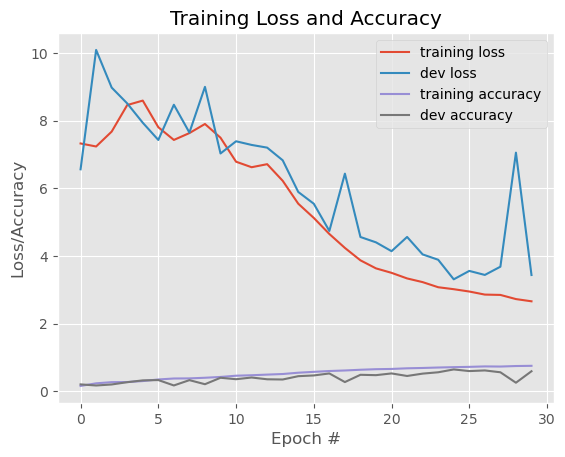

In [21]:
# create a feedforward neural net
#alexnet
from tensorflow.keras.regularizers import l2
height = width = 256
depth = 3
classes = 45
lambda2 = 0.0002
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(96, (11, 11), strides = (4, 4), input_shape = (height, width, depth),
                         padding='same', kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (3,3), strides = (2,2)),
    tf.keras.layers.Dropout(0.25),
        
    tf.keras.layers.Conv2D(256, (5, 5), padding = 'same', kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2)),
    tf.keras.layers.Dropout(0.25),
        
    tf.keras.layers.Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(256, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(4096, kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(4096, kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(classes, kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('softmax')
],name="Alexnet")



model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=maxEpoch
)

Realy = np.concatenate([y for x, y in val_ds], axis = 0)
predY = model.predict(val_ds)
predY = predY.argmax(axis=1)

print(Realy, "\n",predY)
print(classification_report(Realy, predY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


In [ ]:
val_ds
train_ds

Epoch 1/30
788/788 [==============================] - 60s 75ms/step - loss: 21.9903 - accuracy: 0.1126 - val_loss: 16.8559 - val_accuracy: 0.0929
Epoch 2/30
788/788 [==============================] - 59s 75ms/step - loss: 10.6476 - accuracy: 0.1854 - val_loss: 12.0281 - val_accuracy: 0.0944
Epoch 3/30
788/788 [==============================] - 59s 75ms/step - loss: 11.1332 - accuracy: 0.1918 - val_loss: 11.2759 - val_accuracy: 0.1079
Epoch 4/30
788/788 [==============================] - 59s 74ms/step - loss: 11.4729 - accuracy: 0.2085 - val_loss: 20.5129 - val_accuracy: 0.0976
Epoch 5/30
788/788 [==============================] - 59s 75ms/step - loss: 10.7960 - accuracy: 0.2149 - val_loss: 11.7383 - val_accuracy: 0.1584
Epoch 6/30
788/788 [==============================] - 59s 75ms/step - loss: 10.5369 - accuracy: 0.2216 - val_loss: 10.5460 - val_accuracy: 0.1305
Epoch 7/30
788/788 [==============================] - 58s 74ms/step - loss: 9.4507 - accuracy: 0.2325 - val_loss: 9.1401 - v

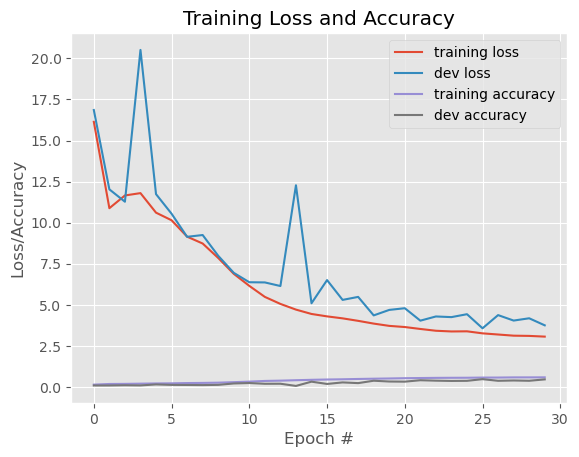

In [22]:
# create a feedforward neural net
#alexnet
from tensorflow.keras.regularizers import l2
height = width = 256
depth = 3
classes = 45
lambda2 = 0.002
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(96, (11, 11), strides = (4, 4), input_shape = (height, width, depth),
                         padding='same', kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (3,3), strides = (2,2)),
    tf.keras.layers.Dropout(0.25),
        
    tf.keras.layers.Conv2D(256, (5, 5), padding = 'same', kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2)),
    tf.keras.layers.Dropout(0.25),
        
    tf.keras.layers.Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(384, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(256, (3, 3), padding = 'same', kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (3, 3), strides = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(4096, kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(4096, kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(classes, kernel_regularizer = l2(lambda2)),
    tf.keras.layers.Activation('softmax')
],name="Alexnet")



model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=maxEpoch
)

Realy = np.concatenate([y for x, y in val_ds], axis = 0)
predY = model.predict(val_ds)
predY = predY.argmax(axis=1)

print(Realy, "\n",predY)
print(classification_report(Realy, predY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
